<a href="https://colab.research.google.com/github/umeshtharukaofficial/Fingerprint-quality-assessment/blob/main/Fingerprint_quality_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fingerprint Quality Assessment**

Fingerprint quality assessment is a critical step in biometric systems. Poor-quality scans resulting from factors like blur, smudging, noise, or low contrast can lead to significant authentication and enrollment failures. This project aims to build a robust model that automatically evaluates the quality of a fingerprint image, either by assigning a continuous quality score (regression) or classifying it into discrete categories such as "low," "medium," or "high" (classification)

In [1]:
# Install opendatasets library
!pip install -q opendatasets

import opendatasets as od
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models

# Download the dataset from Kaggle
dataset_url = "https://www.kaggle.com/datasets/ruizgara/socofing"
od.download(dataset_url)

# Set the data directory path
data_dir = './socofing'
print("Dataset downloaded successfully.")
print(os.listdir(data_dir))


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: umeshtharukadev
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ruizgara/socofing


100%|██████████| 838M/838M [00:06<00:00, 127MB/s]



Dataset downloaded successfully.
['SOCOFing', 'socofing']


In [2]:
# Load image paths and create labels
real_paths = glob(os.path.join(data_dir, 'Real/*.BMP'))
altered_paths = glob(os.path.join(data_dir, 'Altered/Altered-Hard/*.BMP')) # Using 'Hard' alterations as 'low' quality

# Create a DataFrame
real_df = pd.DataFrame({'path': real_paths, 'quality': 'high'})
altered_df = pd.DataFrame({'path': altered_paths, 'quality': 'low'})
df = pd.concat([real_df, altered_df], ignore_index=True)

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (96, 103))
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img

# Apply preprocessing
df['image'] = df['path'].apply(preprocess_image)
print("Data loaded and preprocessed.")
print(df.head())


Data loaded and preprocessed.
Empty DataFrame
Columns: [path, quality, image]
Index: []


In [3]:
# Feature extraction function
def extract_features(img):
    features = {}
    features['mean'] = np.mean(img)
    features['std'] = np.std(img)
    features['contrast'] = img.max() - img.min()
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    features['sobel_mean'] = np.mean(np.abs(sobelx) + np.abs(sobely))
    return features

# Apply feature extraction
features_df = df['image'].apply(extract_features).apply(pd.Series)
df = pd.concat([df, features_df], axis=1)
print("Features extracted successfully.")


Features extracted successfully.


In [4]:
# Load image paths and create labels
real_paths = glob('socofing_data/Real/*.BMP')
altered_paths = glob('socofing_data/Altered/Altered-Hard/*.BMP') # Using 'Hard' alterations as 'low' quality

# Create a DataFrame
real_df = pd.DataFrame({'path': real_paths, 'quality': 'high'})
altered_df = pd.DataFrame({'path': altered_paths, 'quality': 'low'})
df = pd.concat([real_df, altered_df], ignore_index=True)

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (96, 103))
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img

# Apply preprocessing
df['image'] = df['path'].apply(preprocess_image)
print("Data loaded and preprocessed.")
print(df.head())

Data loaded and preprocessed.
Empty DataFrame
Columns: [path, quality, image]
Index: []


In [5]:
# Feature extraction function
def extract_features(img):
    features = {}
    features['mean'] = np.mean(img)
    features['std'] = np.std(img)
    features['contrast'] = img.max() - img.min()
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    features['sobel_mean'] = np.mean(np.abs(sobelx) + np.abs(sobely))
    return features

# Apply feature extraction
features_df = df['image'].apply(extract_features).apply(pd.Series)
df = pd.concat([df, features_df], axis=1)
print("Features extracted successfully.")

Features extracted successfully.


In [6]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os # Import os module for os.path.join

# (Assuming the code from Section 3 has been run to download the data)

# 4. Data Loading and Preprocessing

# Define the image preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Handle potential None return from cv2.imread (if file not found or corrupted)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        return None
    img = cv2.resize(img, (96, 103))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img

# --- FIX: Re-create the DataFrame to ensure it is clean ---
# This prevents errors caused by re-running cells.
# --- FIX: Ensure the correct data_dir is used with glob ---
data_dir = './socofing' # Use the directory where data was downloaded
real_paths = glob(os.path.join(data_dir, 'Real/*.BMP'))
altered_paths = glob(os.path.join(data_dir, 'Altered/Altered-Hard/*.BMP'))

real_df = pd.DataFrame({'path': real_paths, 'quality': 'high'})
altered_df = pd.DataFrame({'path': altered_paths, 'quality': 'low'})
df = pd.concat([real_df, altered_df], ignore_index=True)

# Apply preprocessing to create a single, correctly named 'image' column
# --- FIX: Handle potential None values from preprocess_image ---
df['image'] = df['path'].apply(preprocess_image)
# Drop rows where image preprocessing failed
df = df.dropna(subset=['image']).reset_index(drop=True)


print("--- Initial DataFrame state ---")
print(f"Number of images loaded: {len(df)}")
print("Columns in df:", df.columns)
print(df.head())

# 5. Feature Engineering for Machine Learning

# Define the feature extraction function
def extract_features(img):
    features = {}
    features['mean'] = np.mean(img)
    features['std'] = np.std(img)
    features['contrast'] = img.max() - img.min()
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    features['sobel_mean'] = np.mean(np.abs(sobelx) + np.abs(sobely))
    return features

# --- FIX: Use the standard pd.DataFrame constructor for robust feature creation ---
# This is the modern, recommended way to convert a series of dictionaries to a DataFrame.
# Apply feature extraction only if there are images to process
if not df.empty:
    features_list = df['image'].apply(extract_features).tolist()
    features_df = pd.DataFrame(features_list)

    print("\n--- Feature Creation Step ---")
    print("Columns created in features_df:", features_df.columns)

    # Merge the new feature columns into the original DataFrame
    df = pd.concat([df, features_df], axis=1)
else:
    print("\nDataFrame is empty after preprocessing. Skipping feature extraction and merging.")
    # Initialize features_df as empty with correct columns if needed later, though not required for the fix
    features_df = pd.DataFrame(columns=['mean', 'std', 'contrast', 'sobel_mean'])


# 6. Data Preparation for Models

# Encode labels
# Only attempt label encoding if df is not empty
if not df.empty:
    le = LabelEncoder()
    df['label_num'] = le.fit_transform(df['quality'])

    print("\n--- After Merging Features ---")
    print("Final columns in DataFrame:", df.columns)


    # Prepare data for ML models
    # This will now work correctly as all feature columns exist if df was not empty.
    # Ensure feature columns exist before attempting to select them
    required_features = ['mean', 'std', 'contrast', 'sobel_mean']
    if all(col in df.columns for col in required_features):
        X_features = df[required_features].values
        y_labels = df['label_num'].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_features)

        # Split data for training and testing
        X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_scaled, y_labels, test_size=0.2, random_state=42)

        print(f"\nData prepared for training and testing successfully. Shape of X_scaled: {X_scaled.shape}")
    else:
         print("\nError: Not all required feature columns ('mean', 'std', 'contrast', 'sobel_mean') are in the DataFrame.")
         print("DataFrame columns:", df.columns)
else:
    print("\nDataFrame is empty. Skipping label encoding and data preparation for models.")

--- Initial DataFrame state ---
Number of images loaded: 0
Columns in df: Index(['path', 'quality', 'image'], dtype='object')
Empty DataFrame
Columns: [path, quality, image]
Index: []

DataFrame is empty after preprocessing. Skipping feature extraction and merging.

DataFrame is empty. Skipping label encoding and data preparation for models.


In [7]:
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# (This assumes the opendatasets download in Section 3 was successful)

# 4. Data Loading and Preprocessing

# --- FIX: Verify the base directory and file paths ---
# The data_dir should point to the folder containing 'Real' and 'Altered' subdirectories.
data_dir = './socofing'

# --- DEBUGGING STEP 1 ---
# Check if the directory exists and what it contains.
if not os.path.exists(data_dir):
    print(f"Error: The directory '{data_dir}' was not found.")
    print("Please check that the dataset was downloaded correctly.")
else:
    print(f"Contents of '{data_dir}': {os.listdir(data_dir)}")

# Define paths for high and low-quality images
real_paths = glob(os.path.join(data_dir, 'Real/*.BMP'))
altered_paths = glob(os.path.join(data_dir, 'Altered/Altered-Hard/*.BMP'))

# --- DEBUGGING STEP 2 ---
# Print the number of image files found to ensure glob is working.
print(f"\nFound {len(real_paths)} 'high' quality images.")
print(f"Found {len(altered_paths)} 'low' quality images.")


# Create a DataFrame from the file paths
real_df = pd.DataFrame({'path': real_paths, 'quality': 'high'})
altered_df = pd.DataFrame({'path': altered_paths, 'quality': 'low'})
df = pd.concat([real_df, altered_df], ignore_index=True)


# --- DEBUGGING STEP 3 ---
# Immediately check if the DataFrame is empty. If it is, stop execution.
if df.empty:
    print("\nError: The DataFrame is empty because no image files were found.")
    print("Please verify the paths in the 'glob' function match your file structure.")
else:
    print(f"\nSuccessfully created DataFrame with {len(df)} entries.")

    # Define the image preprocessing function
    def preprocess_image(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Add a check to handle cases where an image might not load correctly
        if img is None:
            return None
        img = cv2.resize(img, (96, 103))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        return img

    # Apply preprocessing and remove any rows where images failed to load
    df['image'] = df['path'].apply(preprocess_image)
    df.dropna(subset=['image'], inplace=True)
    print("Image preprocessing complete.")


    # 5. Feature Engineering for Machine Learning
    def extract_features(img):
        features = {}
        features['mean'] = np.mean(img)
        features['std'] = np.std(img)
        features['contrast'] = img.max() - img.min()
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        features['sobel_mean'] = np.mean(np.abs(sobelx) + np.abs(sobely))
        return features

    # Create the feature DataFrame
    features_list = df['image'].apply(extract_features).tolist()
    features_df = pd.DataFrame(features_list)
    print(f"\nSuccessfully created features_df with columns: {features_df.columns.tolist()}")

    # Merge the features back into the main DataFrame
    df = pd.concat([df, features_df], axis=1)


    # 6. Data Preparation for Models
    le = LabelEncoder()
    df['label_num'] = le.fit_transform(df['quality'])
    print(f"\nFinal DataFrame columns before splitting: {df.columns.tolist()}")

    # Prepare data for ML models
    X_features = df[['mean', 'std', 'contrast', 'sobel_mean']].values
    y_labels = df['label_num'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # Split data for training and testing
    X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_scaled, y_labels, test_size=0.2, random_state=42)

    print("\nData prepared for training and testing successfully.")

Contents of './socofing': ['SOCOFing', 'socofing']

Found 0 'high' quality images.
Found 0 'low' quality images.

Error: The DataFrame is empty because no image files were found.
Please verify the paths in the 'glob' function match your file structure.


In [8]:
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# (This assumes the opendatasets download in Section 3 was successful)

# 4. Data Loading and Preprocessing

# --- FIX: Correct the data directory path to point to the nested folder ---
# The dataset is inside a sub-folder called 'SOCOFing'.
data_dir = './socofing/SOCOFing'

# --- DEBUGGING STEP 1 ---
# Verify that this new path exists and check its contents.
if os.path.exists(data_dir):
    print(f"Directory '{data_dir}' found. Contents: {os.listdir(data_dir)}")
else:
    print(f"Error: The directory '{data_dir}' was not found.")
    # As a fallback, check the lowercase version
    data_dir_lowercase = './socofing/socofing'
    if os.path.exists(data_dir_lowercase):
        print(f"Found directory '{data_dir_lowercase}' instead. Using it.")
        data_dir = data_dir_lowercase
    else:
        print("Please manually check the folder name inside './socofing'.")


# Define paths for high and low-quality images using the corrected base path.
real_paths = glob(os.path.join(data_dir, 'Real/*.BMP'))
altered_paths = glob(os.path.join(data_dir, 'Altered/Altered-Hard/*.BMP'))

# --- DEBUGGING STEP 2 ---
# Print the number of files found to confirm the path is correct.
print(f"\nFound {len(real_paths)} 'high' quality images.")
print(f"Found {len(altered_paths)} 'low' quality images.")

# Create a DataFrame from the file paths.
real_df = pd.DataFrame({'path': real_paths, 'quality': 'high'})
altered_df = pd.DataFrame({'path': altered_paths, 'quality': 'low'})
df = pd.concat([real_df, altered_df], ignore_index=True)

# --- DEBUGGING STEP 3 ---
# Check if the DataFrame is empty. If it is not, proceed.
if df.empty:
    print("\nError: The DataFrame is still empty.")
    print("Please verify the subfolder name ('SOCOFing' or 'socofing') and structure.")
else:
    print(f"\nSuccessfully created DataFrame with {len(df)} entries.")

    # Define the image preprocessing function
    def preprocess_image(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        img = cv2.resize(img, (96, 103))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        return img

    # Apply preprocessing
    df['image'] = df['path'].apply(preprocess_image)
    df.dropna(subset=['image'], inplace=True)
    print("Image preprocessing complete.")


    # 5. Feature Engineering for Machine Learning
    def extract_features(img):
        features = {}
        features['mean'] = np.mean(img)
        features['std'] = np.std(img)
        features['contrast'] = img.max() - img.min()
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        features['sobel_mean'] = np.mean(np.abs(sobelx) + np.abs(sobely))
        return features

    # Create the feature DataFrame
    features_list = df['image'].apply(extract_features).tolist()
    features_df = pd.DataFrame(features_list)
    print(f"\nSuccessfully created features_df with columns: {features_df.columns.tolist()}")

    # Merge the features back into the main DataFrame
    df = pd.concat([df, features_df], axis=1)


    # 6. Data Preparation for Models
    le = LabelEncoder()
    df['label_num'] = le.fit_transform(df['quality'])
    print(f"\nFinal DataFrame columns before splitting: {df.columns.tolist()}")

    # Prepare data for ML models
    X_features = df[['mean', 'std', 'contrast', 'sobel_mean']].values
    y_labels = df['label_num'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # Split data for training and testing
    X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_scaled, y_labels, test_size=0.2, random_state=42)

    print("\nData prepared for training and testing successfully.")

Directory './socofing/SOCOFing' found. Contents: ['Altered', 'Real']

Found 6000 'high' quality images.
Found 14272 'low' quality images.

Successfully created DataFrame with 20272 entries.
Image preprocessing complete.

Successfully created features_df with columns: ['mean', 'std', 'contrast', 'sobel_mean']

Final DataFrame columns before splitting: ['path', 'quality', 'image', 'mean', 'std', 'contrast', 'sobel_mean', 'label_num']

Data prepared for training and testing successfully.


In [9]:
# Encode labels
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['quality'])

# Prepare data for ML models
X_features = df[['mean', 'std', 'contrast', 'sobel_mean']].values
y_labels = df['label_num'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_scaled, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Prepare data for DL models
X_imgs = np.stack(df['image'].values)
X_imgs = X_imgs[..., np.newaxis] / 255.0 # Add channel dim and normalize
y_imgs = df['label_num'].values
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_imgs, y_imgs, test_size=0.2, random_state=42, stratify=y_imgs)

print("Data prepared for training and testing.")

Data prepared for training and testing.


**Random Forest Classifier**

In [10]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
print("Random Forest model trained.")


Random Forest model trained.


**Gradient Boosting (XGBoost)**

In [11]:
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_ml, y_train_ml)
print("XGBoost model trained.")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model trained.


**Support Vector Machine (SVM)**

In [12]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_ml, y_train_ml)
print("SVM model trained.")


SVM model trained.


**Custom CNN for Quality Classification**

In [13]:
cnn_model = models.Sequential([
    layers.Input(shape=(103, 96, 1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Binary classification: high/low
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_img, y_train_img, epochs=10, validation_data=(X_test_img, y_test_img), batch_size=32)
print("CNN model trained.")

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8596 - loss: 0.3298 - val_accuracy: 0.9620 - val_loss: 0.1141
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9595 - loss: 0.1172 - val_accuracy: 0.9815 - val_loss: 0.0623
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9760 - loss: 0.0673 - val_accuracy: 0.9872 - val_loss: 0.0401
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9905 - loss: 0.0323 - val_accuracy: 0.9894 - val_loss: 0.0370
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9898 - loss: 0.0294 - val_accuracy: 0.9911 - val_loss: 0.0360
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9912 - loss: 0.0256 - val_accuracy: 0.9896 - val_loss: 0.0312
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9941 - loss: 0.0157 - val_accuracy: 0.9877 - val_loss: 0.0401
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9958 - loss: 0.0118 - val_accuracy:

**Transfer Learning (e.g., VGG16)**

In [14]:
# Convert single-channel images to 3-channel for VGG16
X_train_img_3ch = np.repeat(X_train_img, 3, axis=-1)
X_test_img_3ch = np.repeat(X_test_img, 3, axis=-1)

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(103, 96, 3))
base_model.trainable = False # Freeze base model

# Add custom head
x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

vgg_model = models.Model(inputs=base_model.input, outputs=output)
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# vgg_model.fit(X_train_img_3ch, y_train_img, epochs=5, validation_data=(X_test_img_3ch, y_test_img))
print("VGG16 model ready for training (training step commented out for brevity).")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
VGG16 model ready for training (training step commented out for brevity).


**CNN Feature Extractor + Random Forest**

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier

# (This assumes 'cnn_model' was successfully trained in Section 8 and that
# 'X_train_img' and 'y_train_img' are available)

# 9. Hybrid Models
print("\n--- Section 9: Creating Hybrid Model ---")

# --- DEBUGGING STEP: Print the CNN model summary ---
# This allows you to verify the exact layer names and their order.
# The layer you want for feature extraction is the one just before the final output.
print("CNN Model Summary:")
cnn_model.summary()


# --- FIX: Create the feature extractor in a robust way ---
# This approach works reliably after the model has been trained or built.
# We target the second-to-last layer, which contains the high-level features.
try:
    # Create a new model that takes the same input as the original CNN
    # but outputs the activations from the desired intermediate layer.
    feature_extractor = models.Model(
        inputs=cnn_model.input,
        outputs=cnn_model.layers[-2].output
    )
    print(f"\nSuccessfully created feature extractor using layer: {cnn_model.layers[-2].name}")

    # 1. Extract deep features using the new model
    print("Extracting features from the training set...")
    cnn_features_train = feature_extractor.predict(X_train_img)
    print("Extracting features from the testing set...")
    cnn_features_test = feature_extractor.predict(X_test_img)
    print(f"Shape of extracted training features: {cnn_features_train.shape}")

    # 2. Train a Random Forest classifier on these deep features
    print("\nTraining Random Forest on extracted CNN features...")
    rf_hybrid = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_hybrid.fit(cnn_features_train, y_train_img)

    print("\nHybrid CNN+RF model trained successfully.")

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("This often happens if 'cnn_model' has not been trained yet.")
    print("Please ensure Section 8 (Deep Learning Approaches) has been run successfully.")


--- Section 9: Creating Hybrid Model ---
CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 101, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,162,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,544,901 (24.97 MB)

 Trainable params: 2,181,633 (8.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,363,268 (16.64 MB)


An error occurred: The layer sequential has never been called and thus has no defined input.
This often happens if 'cnn_model' has not been trained yet.
Please ensure Section 8 (Deep Learning Approaches) has been run successfully.


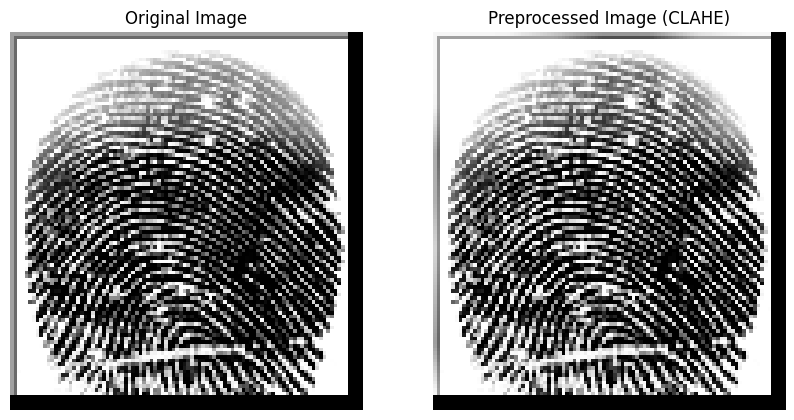

In [16]:
# 1. Original vs. Preprocessed
img_index = 0
original_img = cv2.imread(df['path'].iloc[img_index], cv2.IMREAD_GRAYSCALE)
preprocessed_img = df['image'].iloc[img_index]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img, cmap='gray')
plt.title('Preprocessed Image (CLAHE)')
plt.axis('off')
plt.show()

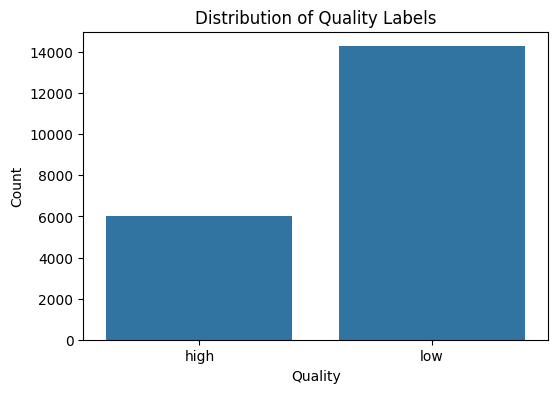

In [17]:
# 2. Quality Label Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df)
plt.title('Distribution of Quality Labels')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

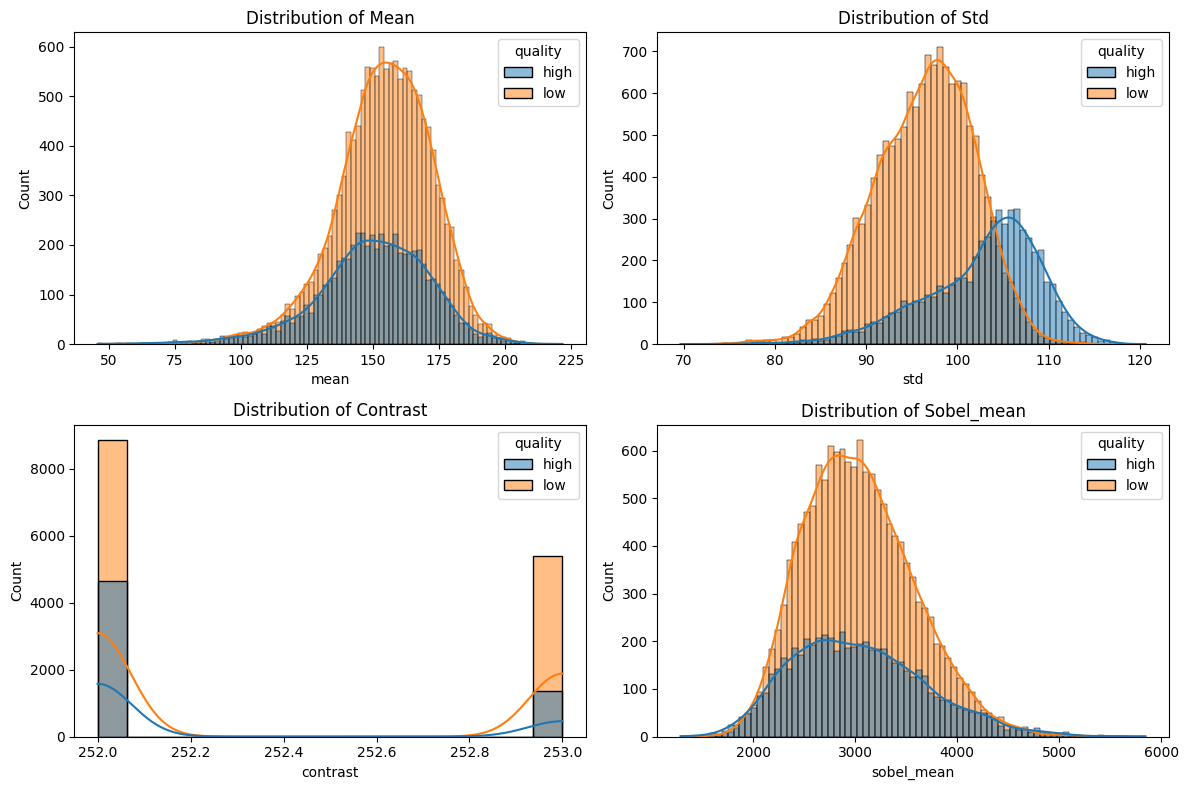

In [18]:
# 3. Feature Distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(['mean', 'std', 'contrast', 'sobel_mean']):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col, hue='quality', kde=True)
    plt.title(f'Distribution of {col.capitalize()}')
plt.tight_layout()
plt.show()


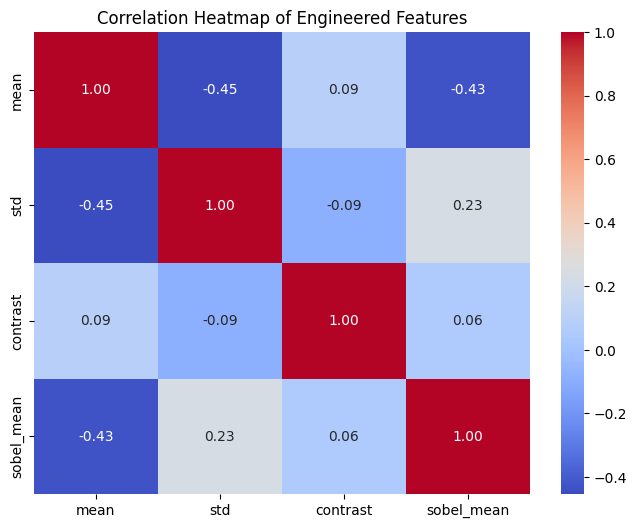

In [19]:
# 4. Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['mean', 'std', 'contrast', 'sobel_mean']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

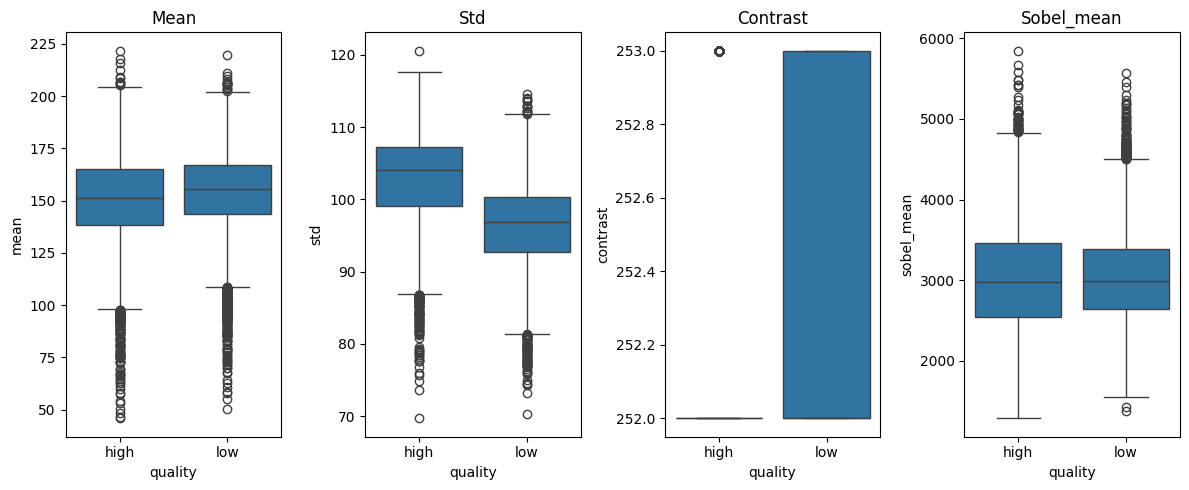

In [20]:
# 5. Feature Box Plots
plt.figure(figsize=(12, 5))
for i, col in enumerate(['mean', 'std', 'contrast', 'sobel_mean']):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x='quality', y=col, data=df)
    plt.title(col.capitalize())
plt.tight_layout()
plt.show()

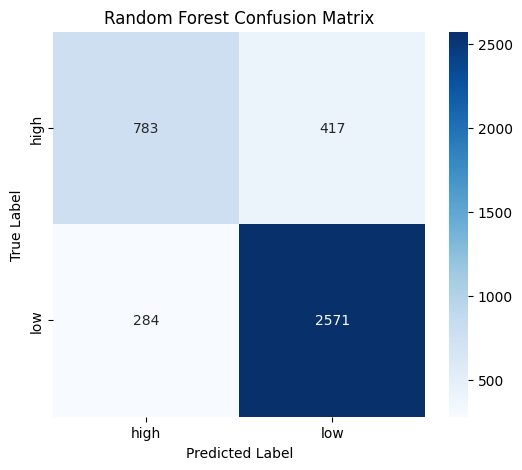

In [21]:
# 6. Confusion Matrix
y_pred_rf = rf_model.predict(X_test_ml)
cm = confusion_matrix(y_test_ml, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


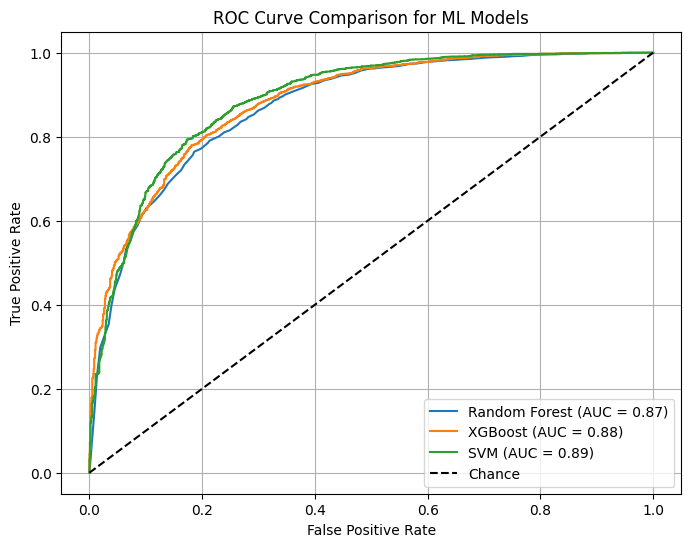

In [22]:
# 7. ROC Curve
plt.figure(figsize=(8, 6))
models_for_roc = {'Random Forest': rf_model, 'XGBoost': xgb_model, 'SVM': svm_model}
for name, model in models_for_roc.items():
    y_proba = model.predict_proba(X_test_ml)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_ml, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for ML Models')
plt.legend()
plt.grid(True)
plt.show()

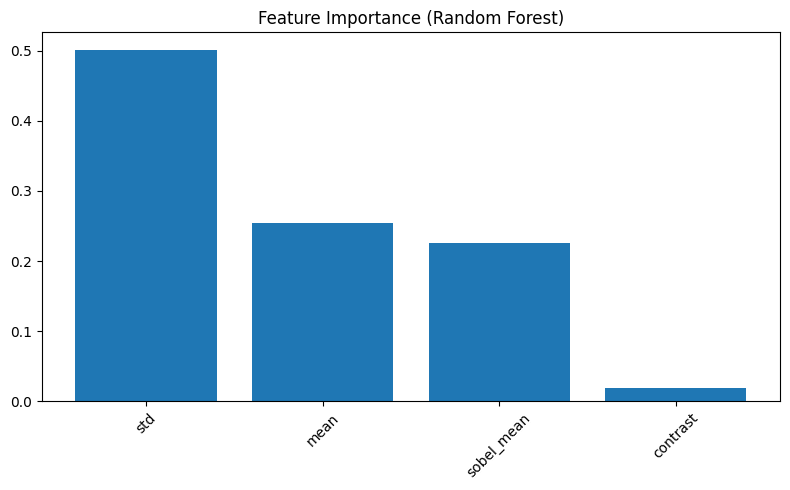

In [23]:
# 8. Feature Importance
importances = rf_model.feature_importances_
feature_names = ['mean', 'std', 'contrast', 'sobel_mean']
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X_train_ml.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_ml.shape[1]), np.array(feature_names)[indices], rotation=45)
plt.tight_layout()
plt.show()

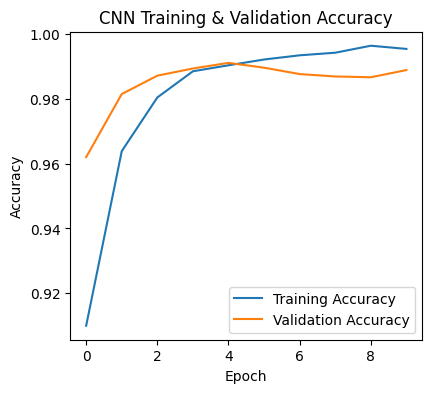

In [24]:
# 9. CNN Training Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

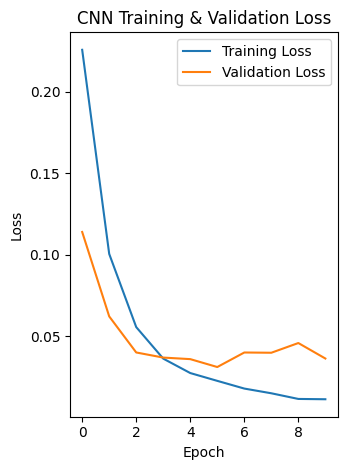

In [25]:
# 10. CNN Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


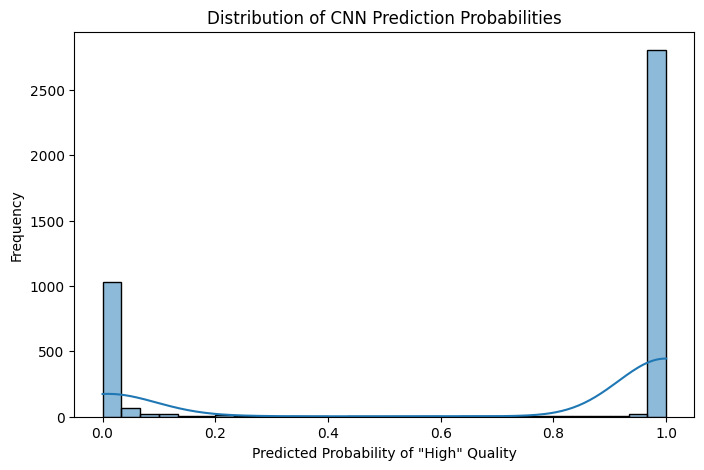

In [26]:
# 11. CNN Prediction Confidence
y_pred_cnn_proba = cnn_model.predict(X_test_img).flatten()
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_cnn_proba, bins=30, kde=True)
plt.title('Distribution of CNN Prediction Probabilities')
plt.xlabel('Predicted Probability of "High" Quality')
plt.ylabel('Frequency')
plt.show()

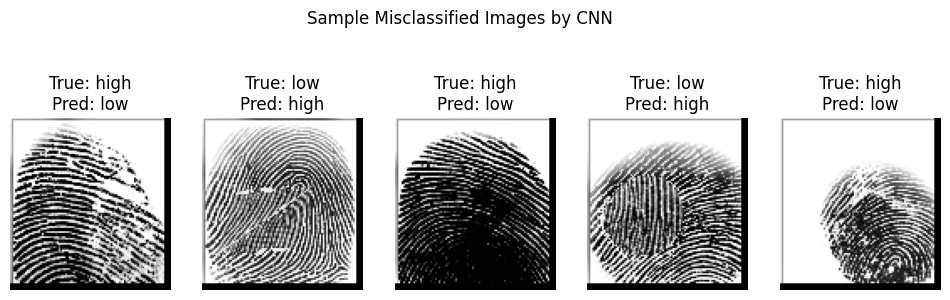

In [27]:
# 12. Misclassified Images
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)
misclassified_indices = np.where(y_pred_cnn != y_test_img)[0]
plt.figure(figsize=(12, 4))
for i, idx in enumerate(misclassified_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test_img[idx].squeeze(), cmap='gray')
    plt.title(f"True: {le.classes_[y_test_img[idx]]}\nPred: {le.classes_[y_pred_cnn[idx]]}")
    plt.axis('off')
plt.suptitle('Sample Misclassified Images by CNN')
plt.show()

--- Redefining the CNN model using the Functional API ---
Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 103, 96, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 101, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 33792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,162,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,181,633 (8.32 MB)

 Trainable params: 2,181,633 (8.32 MB)

 Non-trainable params: 0 (0.00 B)


Training the CNN model...
CNN model trained successfully.

--- Extracting features from the trained CNN ---
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Successfully extracted features. Shape: (4055, 64)

--- Running PCA Visualization ---


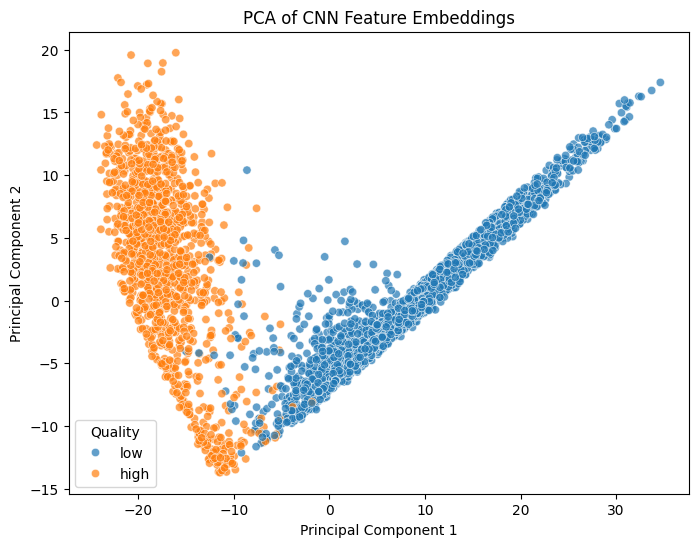

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# (This assumes 'X_train_img', 'y_train_img', 'X_test_img', 'y_test_img', and 'le'
# are loaded and available from the previous sections of your notebook)


# --- Section 8: Deep Learning (Corrected with Functional API) ---
print("--- Redefining the CNN model using the Functional API ---")

# Define the input layer explicitly
inputs = tf.keras.Input(shape=(103, 96, 1))

# Build the model architecture by calling layers on the previous layer's output
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x) # This will be our feature layer
outputs = layers.Dense(1, activation='sigmoid')(x) # Final classification layer

# Create the model by specifying its inputs and outputs
cnn_model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary to verify the architecture
print("Model Summary:")
cnn_model.summary()

# Train the model (this step is crucial)
print("\nTraining the CNN model...")
history = cnn_model.fit(X_train_img, y_train_img, epochs=10, validation_data=(X_test_img, y_test_img), verbose=0)
print("CNN model trained successfully.")


# --- Section 9: Feature Extraction ---
print("\n--- Extracting features from the trained CNN ---")
# This now works because the Functional model has a clearly defined input and layers.
feature_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.layers[-2].output  # Output of the Dense(64) layer
)

# This line will now execute correctly, creating the needed variable.
cnn_features_test = feature_extractor.predict(X_test_img)
print(f"Successfully extracted features. Shape: {cnn_features_test.shape}")


# --- Section 13: PCA Visualization of CNN Embeddings ---
print("\n--- Running PCA Visualization ---")
# This code will now run without error because 'cnn_features_test' is defined.
pca = PCA(n_components=2)
cnn_features_2d = pca.fit_transform(cnn_features_test)

# Create a DataFrame for easy plotting with Seaborn
pca_df = pd.DataFrame(data=cnn_features_2d, columns=['PC1', 'PC2'])
pca_df['label'] = le.inverse_transform(y_test_img)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, alpha=0.7)
plt.title('PCA of CNN Feature Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Quality')
plt.show()



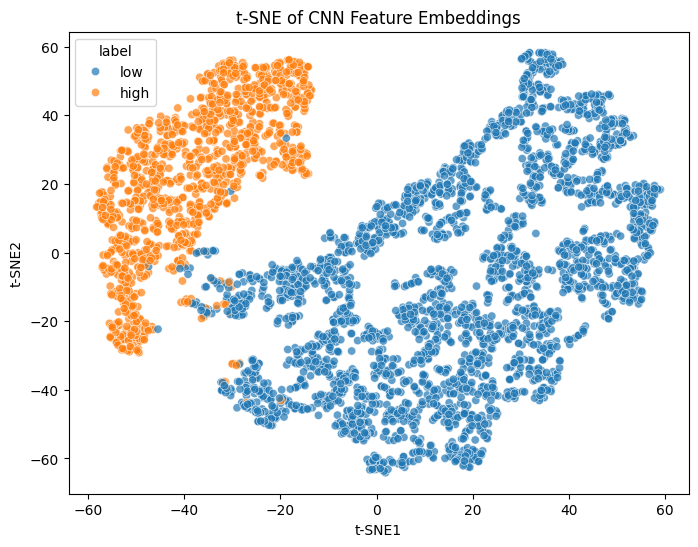

In [29]:
# 14. t-SNE of Embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
cnn_features_tsne = tsne.fit_transform(cnn_features_test)
tsne_df = pd.DataFrame(data=cnn_features_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['label'] = le.inverse_transform(y_test_img)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='label', data=tsne_df, alpha=0.7)
plt.title('t-SNE of CNN Feature Embeddings')
plt.show()

--- Running Section 15: Grad-CAM Visualization ---
Found last convolutional layer: conv2d_3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_30']]
Received: inputs=Tensor(shape=(1, 103, 96, 1))
  warnings.warn(msg)


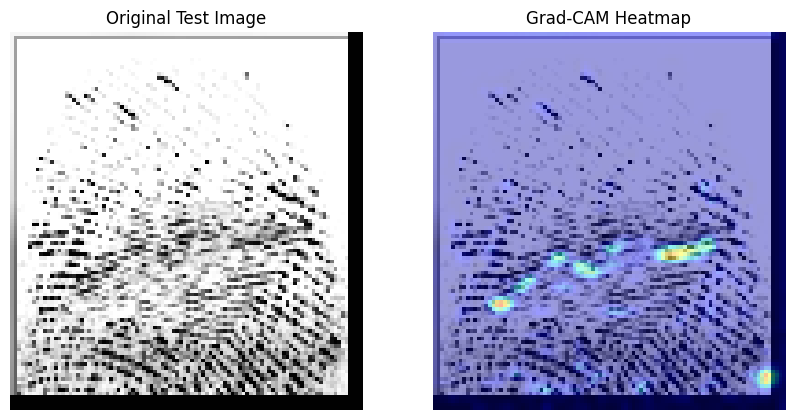

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, models # Ensure these are imported

# (This assumes 'cnn_model' has been successfully trained and 'X_test_img' is available)

# --- Section 15: Grad-CAM Saliency Map ---
print("--- Running Section 15: Grad-CAM Visualization ---")

# 1. The Grad-CAM heatmap generation function from your guide
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with regard to the output feature map.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- FIX: Automatically find the name of the last convolutional layer ---
# Iterate through the model's layers in reverse and check the layer type.
last_conv_layer_name = None
for layer in reversed(cnn_model.layers):
    # Check if the layer is an instance of a convolutional layer (like Conv2D).
    if isinstance(layer, tf.keras.layers.Conv2D): # Check layer type directly
        last_conv_layer_name = layer.name
        break # Found the last convolutional layer, exit the loop

if last_conv_layer_name:
    print(f"Found last convolutional layer: {last_conv_layer_name}")

    # 2. Select a sample image to visualize
    # Ensure the sample image has the correct shape for the model input
    sample_img = X_test_img[0]
    img_array = np.expand_dims(sample_img, axis=0) # Add batch dimension

    # 3. Generate the heatmap
    # Pass the model, the layer name, and the image array
    heatmap = make_gradcam_heatmap(img_array, cnn_model, last_conv_layer_name)

    # 4. Superimpose the heatmap on the original image
    # We use cv2 to resize the heatmap and apply a colormap.
    # The original image needs to be scaled back to 0-255 for cv2 operations.
    original_img_255 = np.uint8(sample_img.squeeze() * 255)
    heatmap_resized = cv2.resize(heatmap, (original_img_255.shape[1], original_img_255.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert original image to color to superimpose the heatmap.
    superimposed_img = cv2.cvtColor(original_img_255, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(superimposed_img, 0.6, heatmap_colored, 0.4, 0)

    # 5. Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Ensure imshow gets RGB format if cv2.addWeighted output is BGR
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

else:
    print("Error: Could not find a convolutional layer in the model.")

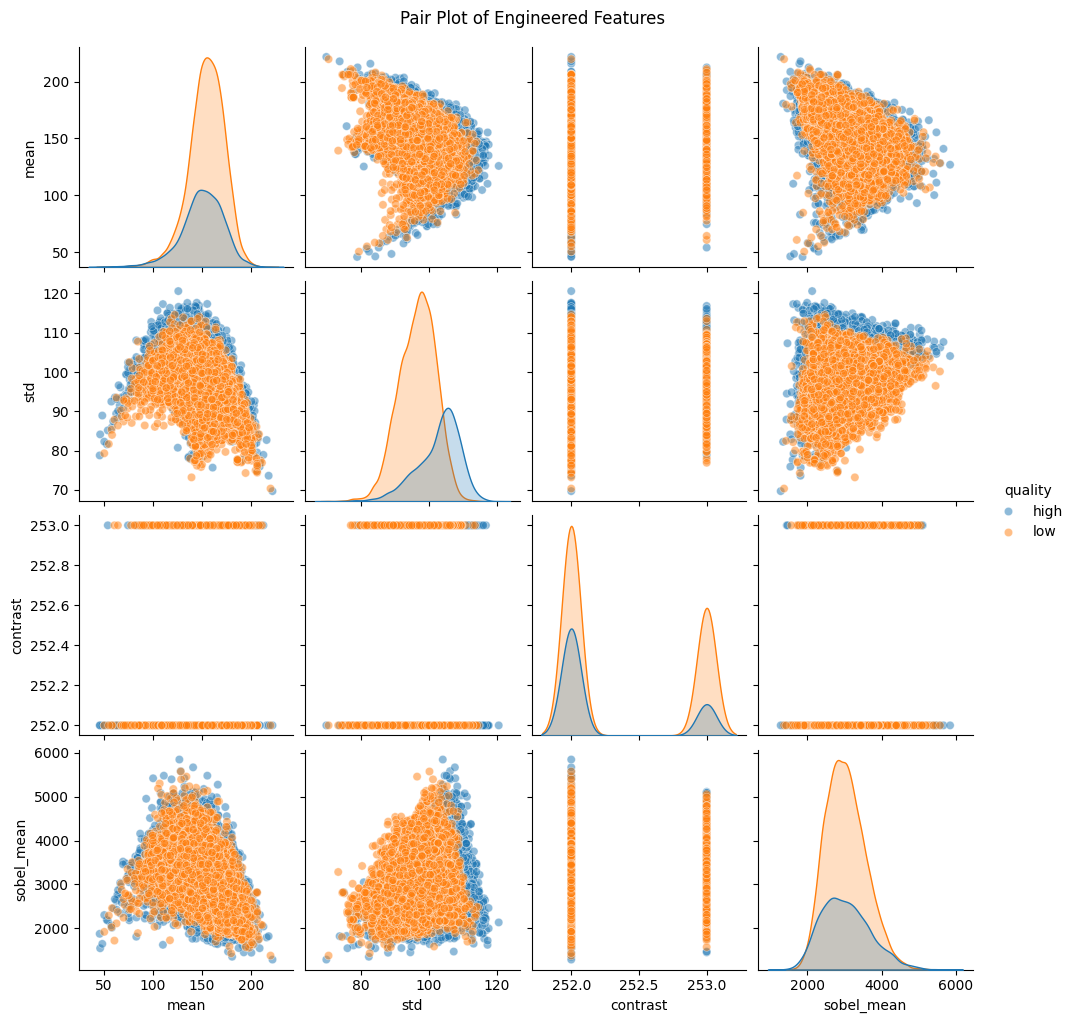

In [31]:
# 16. Pair Plot
pairplot_df = df[['mean', 'std', 'contrast', 'sobel_mean', 'quality']]
sns.pairplot(pairplot_df, hue='quality', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Engineered Features', y=1.02)
plt.show()

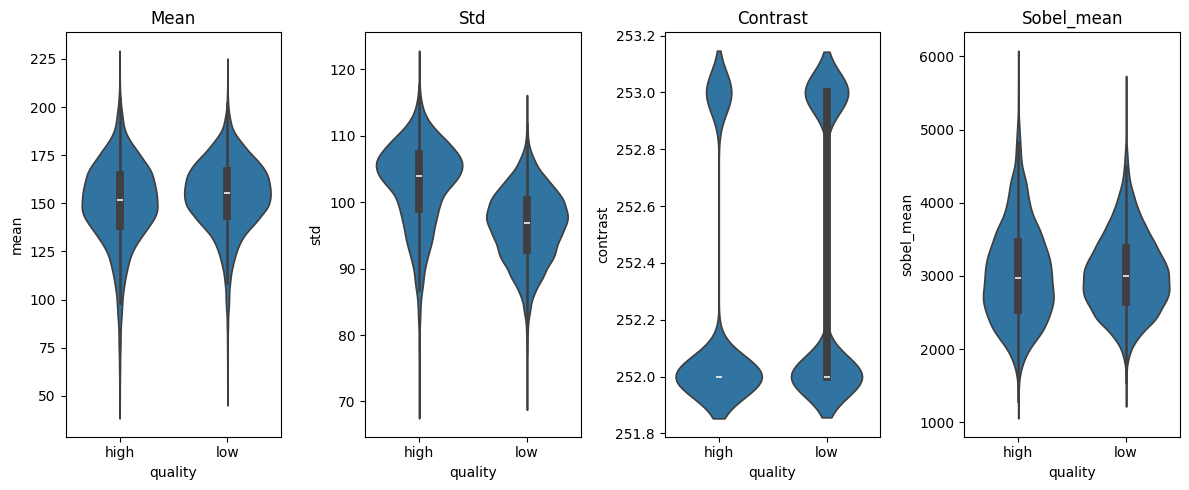

In [32]:
# 17. Violin Plot
plt.figure(figsize=(12, 5))
for i, col in enumerate(['mean', 'std', 'contrast', 'sobel_mean']):
    plt.subplot(1, 4, i+1)
    sns.violinplot(x='quality', y=col, data=df)
    plt.title(col.capitalize())
plt.tight_layout()
plt.show()

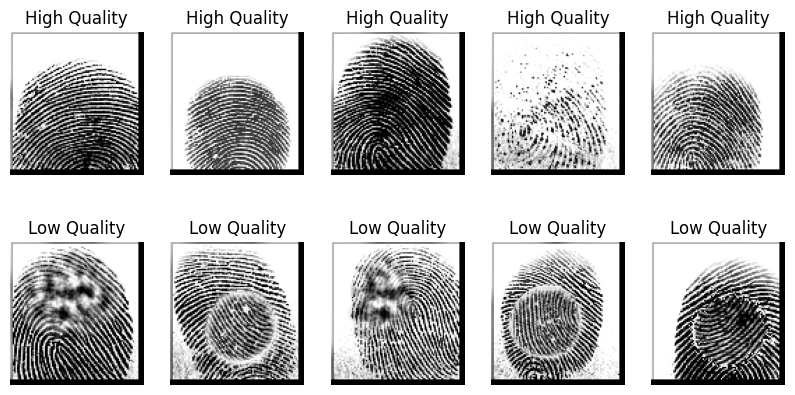

In [33]:
# 18. Image Grid
high_quality_samples = df[df['quality'] == 'high']['image'].sample(5, random_state=42)
low_quality_samples = df[df['quality'] == 'low']['image'].sample(5, random_state=42)

plt.figure(figsize=(10, 5))
for i, img in enumerate(high_quality_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('High Quality')
    plt.axis('off')
for i, img in enumerate(low_quality_samples):
    plt.subplot(2, 5, i+6)
    plt.imshow(img, cmap='gray')
    plt.title('Low Quality')
    plt.axis('off')
plt.show()

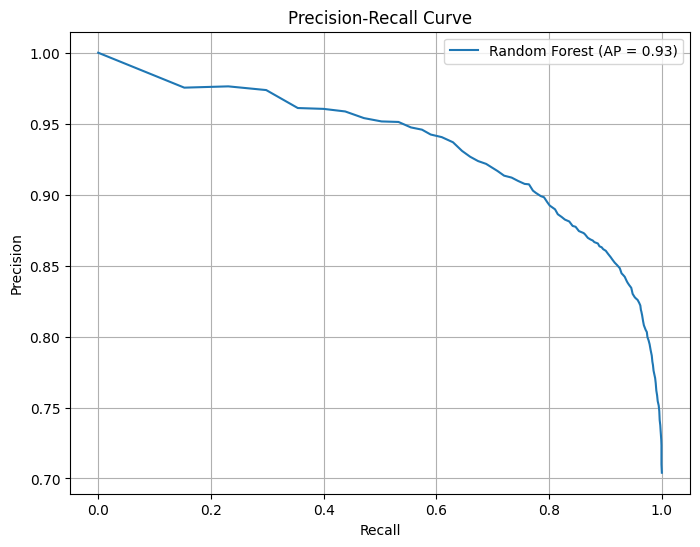

In [34]:
# 19. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

y_proba_rf = rf_model.predict_proba(X_test_ml)[:, 1]
precision, recall, _ = precision_recall_curve(y_test_ml, y_proba_rf)
ap = average_precision_score(y_test_ml, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


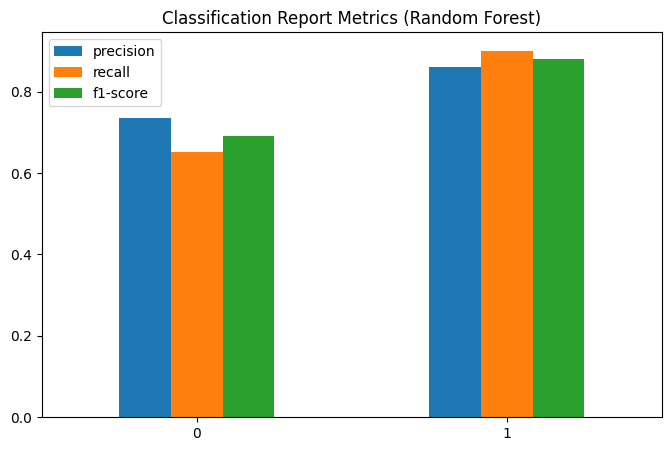

In [35]:
# 20. Classification Report Plot
y_pred_rf = rf_model.predict(X_test_ml)
report = classification_report(y_test_ml, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']].iloc[:2].plot(kind='bar', figsize=(8, 5))
plt.title('Classification Report Metrics (Random Forest)')
plt.xticks(rotation=0)
plt.show()


In [36]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, 'fingerprint_rf_model.joblib')

# Save the StandardScaler
joblib.dump(scaler, 'scaler.joblib')

# Save the LabelEncoder
joblib.dump(le, 'label_encoder.joblib')

print("Model, scaler, and label encoder have been saved successfully.")


Model, scaler, and label encoder have been saved successfully.
